In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import torch as pt
from torch import nn 

In [2]:
def preprocess_inputs(df):

    df = df.copy()
   

    # Drop Route
    df = df.drop(['Route'], axis=1)
    
    # Extract Days and Months from Date of journey
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
    df['Day of Journey'] = df['Date_of_Journey'].dt.day
    df['Month of Journey'] = df['Date_of_Journey'].dt.month
    df = df.drop('Date_of_Journey', axis=1)
   
    
    # Convert and encode departure and arrival time to 4 different times of the day (morning, noon, afternoon, evening)
    df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.hour/6
    df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.hour/6
    
    # Duration converting to minutes
    df['H'] = df['Duration'].str.extract(r'(\d*(?=h))')
    df['M'] = df['Duration'].str.extract(r'(\d*(?=m))')
    df[['H', 'M']] = df[['H', 'M']].fillna(0)
    df[['H', 'M']] = df[['H', 'M']].astype(int)
    df['Duration'] = df['H'] * 60 + df['M']
    df = df.drop(['H', 'M'], axis=1)
    


    # Features from Additional info and total stops 
    
    df['Total_Stops']=df['Total_Stops'].map({'non-stop':0 ,'1 stop':1 ,'2 stops':2,'3 stops':3,'4 stops':4})
    df['Meal'] = df['Additional_Info'].map({'In-flight meal not included':1, 'No info':0})
    df['Baggage'] = df['Additional_Info'].map({'No check-in baggage included':1,'No info':0 })
    df = df.drop('Additional_Info', axis=1)
    
    
    # Source, Destination and Airline encoding (One-hot)
    df = pd.concat([df, pd.get_dummies(df['Source'], prefix='S')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Destination'], prefix='D')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Airline'])], axis=1)
    df = df.drop(['Source', 'Destination','Airline'], axis=1)
   
    df = df.fillna(0) #to avoid null values 
    
    
    #find mean and standard deviation of the price
    mean = df['Price'].mean()
    std = df['Price'].std()
    min = df['Price'].min()
    max = df['Price'].max()

    
   
    # Split X and y
    X = df.drop(['Price'], axis=1)
    y = np.log(df['Price'])
    X_scaled = (X -np.min(X))/(np.max(X)-np.min(X))
    y_scaled = (y -np.min(y))/(np.max(y)-np.min(y))

    
    # Train-test-validation split   
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    """
    #exploratory data analysis
    corr = df.corr() #to see the correlation between each feature and the price 
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.corr(),cmap = 'coolwarm', annot=False)
    """
    
    return X_train, X_val, X_test, y_train, y_val, y_test, mean, std, min, max




In [12]:
# Define your PyTorch neural network
# Number of Inputs: 31
# Number of Hidden Units: 100
# Number of Hidden Layers: 2
# Activation Function:  LeakyReLU
# Number of Outputs: 1
def create_model():
    model = nn.Sequential(
        nn.Linear(31, 100),
        nn.LeakyReLU(),
        nn.Linear(100, 100),
        nn.LeakyReLU(),
        nn.Linear(100, 1)
    )
    return model

# Define your loss function
# Loss Function: Mean Squared Error

def create_loss_fn():
    loss_fn = nn.MSELoss()
    return loss_fn

# Define your optimizer
# Optimizer: Adam
# Learning Rate: 0.001

def create_optimizer(model):
    optimizer = pt.optim.Adam(model.parameters(), lr=0.001)
    return optimizer

# Define your training loop
# Number of Epochs: 1000
# Batch Size: 32

def train_loop(model, loss_fn, optimizer, X_train, y_train, X_val, y_val):
    for epoch in range(1000):
        model.train()
        batch_size = 32
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0: 
            model.eval()
            with pt.no_grad():
                y_pred = model(X_val)
                loss = loss_fn(y_pred, y_val)
                print(f'Epoch: {epoch}, Validation Loss: {loss}')

# Define your evaluation loop
# Batch Size: 32

def eval_loop(model, loss_fn, X_val, y_val):
    model.eval()
    batch_size = 32
    with pt.no_grad():
        for i in range(0, X_val.shape[0], batch_size):
            X_batch = X_val[i:i+batch_size]
            y_batch = y_val[i:i+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
    return loss.item()

# Define your prediction loop
# Batch Size: 32

def predict_loop(model, X_test):
    model.eval()
    batch_size = 32
    y_pred = []
    with pt.no_grad():
        for i in range(0, X_test.shape[0], batch_size):
            X_batch = X_test[i:i+batch_size]
            y_pred_batch = model(X_batch)
            y_pred.append(y_pred_batch)
    y_pred = pt.cat(y_pred)
    return y_pred

#plot prediction vs actual price
def plot_prediction(y_pred, y_test, mean, std, min, max):
    y_pred = y_pred*std + mean
    y_test = y_test*std + mean
    plt.figure(figsize=(12,10))
    plt.plot(y_test, y_pred, 'o')
    plt.plot([min, max], [min, max], 'r')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.show()


In [11]:
# Define your main function
# Load the data
# Create the model
# Create the loss function
# Create the optimizer
# Train the model
# Evaluate the model
# Make predictions
# Save the predictions to a CSV file

data = pd.read_excel('Data_Train.xlsx')
X_train, X_val, X_test, y_train, y_val, y_test, mean, std, min, max = preprocess_inputs(data)
#all outputs to tensor
X_train = pt.tensor(X_train.values, dtype=pt.float32)
X_val = pt.tensor(X_val.values, dtype=pt.float32)
X_test = pt.tensor(X_test.values, dtype=pt.float32)
y_train = pt.tensor(y_train.values, dtype=pt.float32)
y_val = pt.tensor(y_val.values, dtype=pt.float32)
y_test = pt.tensor(y_test.values, dtype=pt.float32)
model = create_model()
loss_fn = create_loss_fn()
optimizer = create_optimizer(model)
train_loop(model, loss_fn, optimizer, X_train, y_train, X_val, y_val)
loss = eval_loop(model, loss_fn, X_val, y_val)
y_pred = predict_loop(model, X_test)
y_pred = y_pred.detach().numpy()
y_pred = y_pred * (max - min) + min
y_pred = pd.DataFrame(y_pred, columns=['Price'])
y_pred.to_csv('predictions.csv', index=False)


/var/folders/fk/fnjsfmtx3kz8w_rw6p8q4zzm0000gn/T/ipykernel_68341/1705441385.py:10: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(a

Epoch: 0, Validation Loss: 0.019369566813111305
Epoch: 100, Validation Loss: 0.01938094012439251
Epoch: 200, Validation Loss: 0.01950283907353878
Epoch: 300, Validation Loss: 0.01958843693137169
Epoch: 400, Validation Loss: 0.019665688276290894
Epoch: 500, Validation Loss: 0.019705915823578835
Epoch: 600, Validation Loss: 0.019793128594756126
Epoch: 700, Validation Loss: 0.01983158104121685
Epoch: 800, Validation Loss: 0.019862832501530647
Epoch: 900, Validation Loss: 0.01990406960248947


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


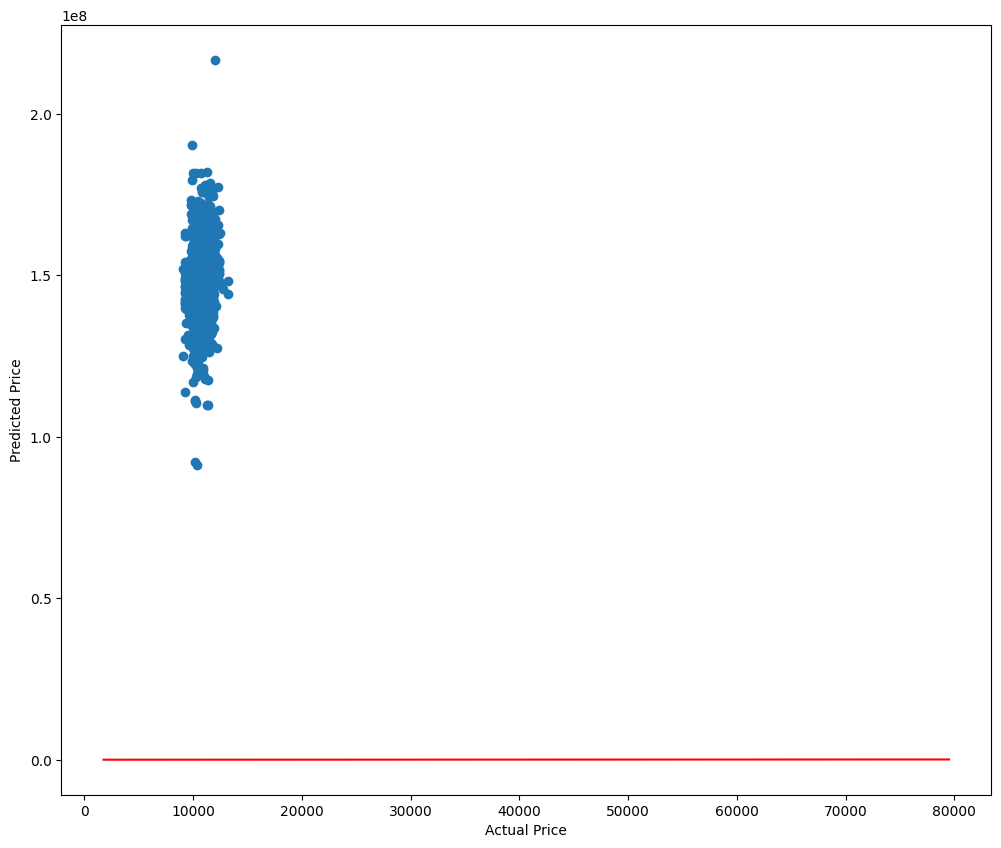

In [13]:
#plot prediction vs actual price
plot_prediction(y_pred, y_test, mean, std, min, max)